# Modelos de Difusión (Stable Diffusion)

En este laboratorio intentaremos hacer un modelo de difusión basado en el modelo de `Stable Diffuision`. Para esto, primero debemos entender el modelo de difusión.

El modelo de `Stable Diffusion` es una extensión del concepto clásico de difusión, utilizado para describir cómo se propaga un fenómeno o sustancia a lo largo del tiempo y del espacio. A diferencia de la difusión normal, la difusión estable puede tener varianza infinita, permitiendo eventos extremos o rarezas en el proceso. Se caracteriza por un parámetro llamado índice de estabilidad alpha (α), que determina la forma de la distribución de probabilidad de las posiciones. Cuanto mayor sea el valor de alpha, más pesadas serán las colas de la distribución, indicando una mayor probabilidad de eventos extremos. Este modelo se aplica en diversas áreas como finanzas, meteorología y geofísica para entender y predecir eventos inusuales y extremos. En este caso lo usaremos para generar imágenes de rostros de personas.

In [1]:
# importamos las librerias necesarias
import torch # libreria principal
import torchvision # libreria para datasets
import torch.nn as nn # libreria para redes neuronales
import random # libreria para numeros aleatorios
import matplotlib.pyplot as plt # libreria para graficar
import numpy as np # libreria para manejo de matrices
import math # libreria para operaciones matematicas
import tqdm # libreria para barra de progreso
import torch.nn.functional as F # libreria para funciones de activacion

# definimos el dispositivo a utilizar (cpu o gpu)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset de rostros (CelebaAGaze)

Usaremos el dataset CelebaAGaze, que contiene imágenes de caras de personas con diferentes expresiones faciales.

El dataset se puede descargar de Kaggle: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256?select=celeba_hq_256

Las imágenes del dataset están en formato JPG y tienen un tamaño de 256x256 píxeles pero nosotros vamos a trabajar con imágenes de 64x64 píxeles para que el entrenamiento sea más rápido.

In [2]:
# ruta de los datos
root = '../Lab05/datasets/CelebAGaze/'

# transformacion de los datos para el entrenamiento
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64,64)), # redimensionamos las imagenes a 64x64
    torchvision.transforms.RandomHorizontalFlip(), # aplicamos un flip horizontal aleatorio
    torchvision.transforms.ToTensor(), # convertimos la imagen a un tensor
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1) # normalizamos los valores de los pixeles entre -1 y 1
])

# cargamos el dataset de entrenamiento
trainset = torchvision.datasets.ImageFolder(root, transform=transforms)

In [3]:
# tamaño del dataset
len(trainset)

20000

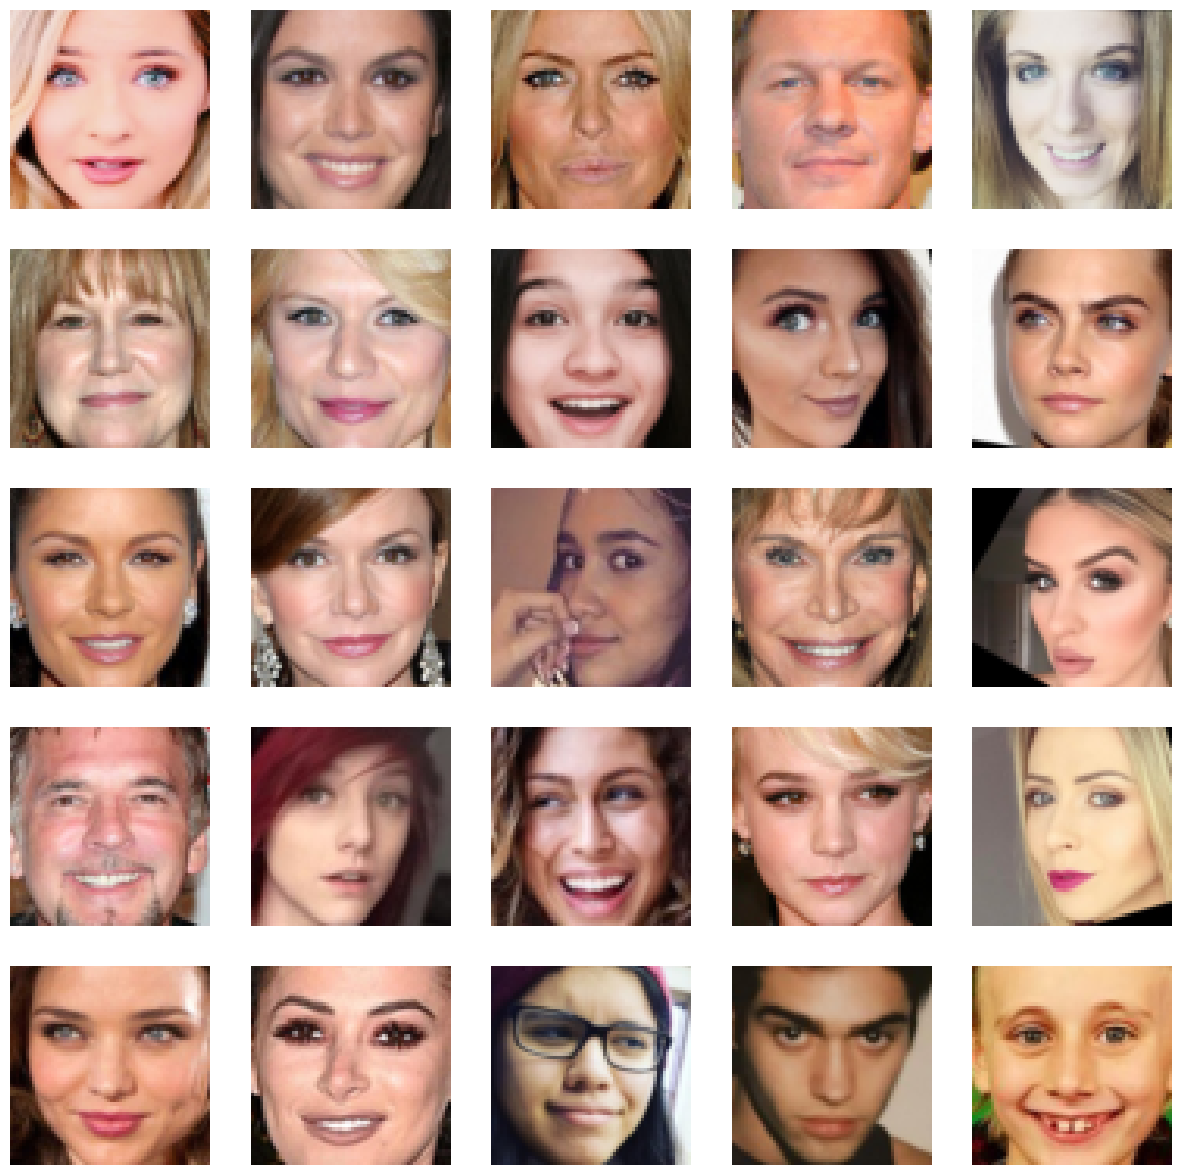

In [4]:
# graficamos algunas imagenes del dataset de entrenamiento (25 imagenes aleatorias)
fig, axs = plt.subplots(5,5, figsize=(15,15))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(trainset)-1)
        img, lab = trainset[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
plt.show()

### Noise Scheduler

La función `noise_scheduler` genera valores de `alpha` y `beta` en un rango específico, calculando también un vector correspondiente llamado `alphas_hat`. Los valores de `beta` se obtienen mediante una secuencia lineal entre 0.0001 y 0.02, y los valores de `alpha` son complementarios a `beta`. El vector `alphas_hat` se crea multiplicando acumulativamente los valores de `alpha`. Este código luego grafica los valores de `alphas_hat` en función del paso, proporcionando una representación visual de cómo estos valores cambian con el tiempo.

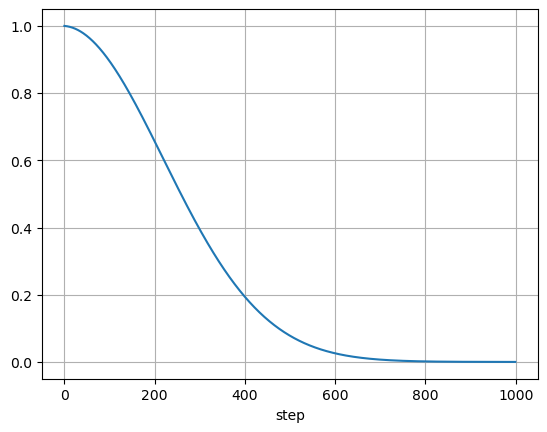

In [5]:
# funcion noise_scheduler para calcular los valores de alpha y beta
def noise_scheduler(start=1e-4, end=0.02, steps=1000):
	betas = torch.linspace(start, end, steps)
	alphas = 1. - betas
	alphas_hat = torch.cumprod(alphas, axis=0) # type: ignore
	return betas, alphas, alphas_hat

_, _, alphas_hat = noise_scheduler()

# graficamos los valores de alpha y beta
plt.plot(alphas_hat)
plt.xlabel('step')
plt.ylabel('', rotation=0)
plt.grid()
plt.show()

### Clase Dataset

El creamos una  clase `Dataset` en PyTorch para manejar datos de aprendizaje profundo. Crea instancias de datos que incluyen imágenes originales, etiquetas y ruido. La clase usa una función `noise_scheduler` para calcular valores de `betas`, `alphas` y `alphas_hat`. Luego, el método `__getitem__` genera datos aplicando ruido a las imágenes originales. En esencia, esta clase prepara datos para entrenar modelos de aprendizaje, introduciendo variabilidad en las imágenes originales.

In [6]:
# definimos la clase Dataset para cargar los datos
class Dataset(torch.utils.data.Dataset):
	def __init__(self, data, T=1000):
		self.data = data
		self.T = T
		self.betas, self.alphas, self.alphas_hat = noise_scheduler(steps=T)

	def __len__(self):
		return len(self.data)

	def __getitem__(self, ix):
		im = self.data[ix][0] # imagen original
		y = torch.tensor([self.data[ix][1]]) # etiqueta
		t = torch.randint(0, self.T, (1,)) # se obtiene un numero aleatorio
		noise = torch.randn_like(im) # ruido
		x = noise * torch.sqrt(1 - self.alphas_hat[t]) + im * torch.sqrt(self.alphas_hat[t]) # imagen con ruido
		return x.float(), noise.float(), t, y

In [7]:
# cargamos el dataset de entrenamiento
dataset = Dataset(trainset)

In [8]:
# mostramos las dimensiones de una imagen, el ruido, el numero aleatorio y la etiqueta
img,noise,t,y = dataset[1]
img.shape,noise.shape,t.shape,y.shape

(torch.Size([3, 64, 64]),
 torch.Size([3, 64, 64]),
 torch.Size([1]),
 torch.Size([1]))

In [9]:
# sacamos los valores min y max de la imagen y el ruido
img.max(), img.min(), noise.max(), noise.min()

(tensor(3.0685), tensor(-3.4504), tensor(3.9192), tensor(-4.1442))

In [10]:
# mostramos el numero aleatorio y la etiqueta de la imagen
t, y

(tensor([318]), tensor([0]))

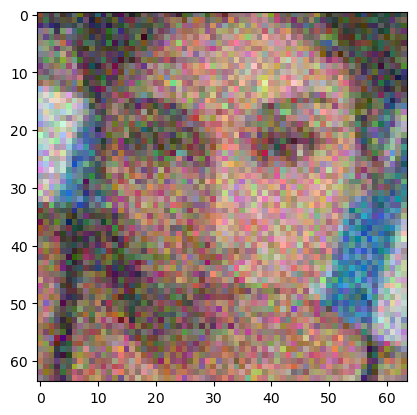

In [11]:
# graficamos la imagen con ruido
normalized_img = torch.clamp((img - noise + 1) / 2, 0, 1)
plt.imshow(normalized_img.permute(1, 2, 0))

In [12]:
# cargamos el dataset de entrenamiento en un DataLoader para poder iterar sobre el.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, pin_memory=True) # type: ignore

### Clase SinusoidalPositionEmbeddings

`SinusoidalPositionEmbeddings` es un módulo PyTorch que genera incrustaciones sinusoidales basadas en el tiempo de entrada. Calcula valores sinusoidales y cosinusoidales concatenados para representar posiciones en una secuencia. 

Por otro lado, `conv3x3_bn(ci, co)` es una función que aplica una convolución 3x3, normalización por lotes y activación ReLU en una red neuronal convolucional, común para extraer características en datos de entrada.

In [13]:
# definimos la clase SinusoidalPositionEmbeddings
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

### Clase EncoderConv

La clase `EncoderConv` es un módulo de red neuronal en PyTorch que realiza una operación de codificación. Toma tres argumentos durante la inicialización: `ci`, `co`, y `embed_dim`, que representan respectivamente los canales de entrada, los canales de salida y la dimensión de las incrustaciones (embeddings). En el método `forward`, primero aplica capas de convolución seguidas de normalización por lotes y activación ReLU, seguido por un muestreo máximo (MaxPool2d) para reducir las dimensiones. Luego, calcula las incrustaciones (embeddings) lineales basadas en el tiempo (`t`) y las expande para que coincidan con las dimensiones de `x`. Finalmente, suma las incrustaciones a la salida de las capas convolucionales y devuelve el resultado. En resumen, esta clase combina operaciones de convolución y operaciones de embedding para codificar la entrada `x` en un espacio de características.

In [14]:
# definimos la clase EncoderConv
class EncoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.conv1 = conv3x3_bn(ci, co) # convolucion 3x3 con batch normalization y relu
        self.conv2 = conv3x3_bn(co, co) # convolucion 3x3 con batch normalization y relu
        self.embed = torch.nn.Linear(embed_dim, co) # capa lineal

    def forward(self, x, t):
        x = torch.nn.functional.max_pool2d(x, kernel_size=2) # max pooling 2x2
        x = self.conv1(x) # convolucion 3x3 con batch normalization y relu
        x = self.conv2(x) # convolucion 3x3 con batch normalization y relu
        B, C, H, W = x.shape # obtenemos las dimensiones de x
        e = self.embed(t).view(B, C, 1, 1) # capa lineal
        return x + e # retornamos x + e (broadcasting)

### Clase DecoderConv

La clase `DecoderConv` es un módulo de red neuronal en PyTorch que realiza operaciones de decodificación. Durante la inicialización, toma tres argumentos: `ci` y `co` representan los canales de entrada y salida, respectivamente, y `embed_dim` denota la dimensión de las incrustaciones (embeddings). En el método `forward`, se realiza un upsampling de `x1` y se ajusta su tamaño para que coincida con `x2`. Luego, se concatenan `x1` y `x2`, y se aplican capas de convolución seguidas de normalización por lotes y activación ReLU. Posteriormente, se calculan las incrustaciones lineales basadas en el tiempo (`t`) y se expanden para que coincidan con las dimensiones de `x`. Finalmente, se suma este valor a la salida de las capas convolucionales y se devuelve el resultado. En resumen, esta clase combina operaciones de upsampling, convolución y embeddings para decodificar las características y generar una salida.

In [21]:
# definimos la clase DecoderConv
class DecoderConv(torch.nn.Module):
    def __init__(self, ci, co, embed_dim):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(co * 2, co)  # Note the change in input channels for conv1
        self.conv2 = conv3x3_bn(co, co)
        self.embed = torch.nn.Linear(embed_dim, co)

    def forward(self, x1, x2, t):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = torch.nn.functional.pad(x1, (0, diffY, 0, diffX), mode='constant', value=0)  # Apply padding with constant mode
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        B, C, H, W = x.shape
        e = self.embed(t)[:, :, None, None].repeat(1, 1, H, W)
        return x + e

### Clase Unet

La clase `UNet` representa una arquitectura de red neuronal tipo U-Net utilizada en tareas de segmentación de imágenes. Esta red consta de un encoder y un decoder. En el encoder, las capas convolucionales (`conv1` a `conv4`) reducen gradualmente la dimensión de la entrada, extrayendo características complejas. Durante el proceso, se aplican operaciones de codificación (`EncoderConv`) que incorporan información de tiempo (`t`). En el decoder, las capas deconvolucionales (`deconv1` a `deconv3`) aumentan la resolución de la salida y la combinan con características del encoder correspondiente mediante conexiones residuales. La última capa convolucional (`out`) genera la máscara de segmentación final. Esta arquitectura permite capturar tanto detalles finos como características de alto nivel en las imágenes de entrada, lo que la hace adecuada para aplicaciones de segmentación donde la precisión es crucial.

In [22]:
# definimos la clase UNet
class UNet(torch.nn.Module):
    def __init__(self, out_ch=3, in_ch=1, embed_dim=32):
        super().__init__()
        # lista de capas en encoder-decoder con número de filtros
        c = [64, 128, 256, 512]
        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
            conv3x3_bn(in_ch, c[0]),
            conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = EncoderConv(c[0], c[1], embed_dim)
        self.conv3 = EncoderConv(c[1], c[2], embed_dim)
        self.conv4 = EncoderConv(c[2], c[3], embed_dim)
        # capas del decoder
        self.deconv1 = DecoderConv(c[3], c[2], embed_dim)
        self.deconv2 = DecoderConv(c[2], c[1], embed_dim)
        self.deconv3 = DecoderConv(c[1], c[0], embed_dim)
        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], out_ch, 3, padding=1)

    def forward(self, x, t):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1, t)
        x3 = self.conv3(x2, t)
        x = self.conv4(x3, t)
        # decoder
        x = self.deconv1(x, x3, t)
        x = self.deconv2(x, x2, t)
        x = self.deconv3(x, x1, t)
        x = self.out(x)
        return x

### Clase DiffusionModel

La clase `DiffusionModel` es un modelo de difusión que utiliza incrustaciones sinusoidales para el tiempo y una capa lineal para las etiquetas. En el método `forward`, primero calcula las incrustaciones para el tiempo y, si se proporcionan etiquetas, también para las mismas. Luego, pasa estas incrustaciones junto con las imágenes de entrada (`x`) a una red U-Net (`UNet`). La U-Net procesa las características de las imágenes junto con la información de tiempo y etiquetas para generar una salida segmentada. Este modelo es útil para tareas de segmentación de imágenes, incorporando información temporal y de etiquetas para mejorar la precisión del proceso de difusión y segmentación.

In [23]:
# definimos la clase DiffusionModel
class DiffusionModel(torch.nn.Module):
    def __init__(self, embed_dim=32):
        super().__init__()
        self.time_embed = SinusoidalPositionEmbeddings(embed_dim)
        self.label_embed = torch.nn.Linear(3, embed_dim)
        self.unet = UNet(in_ch=3, out_ch=3, embed_dim=embed_dim)

    def forward(self, x, t, y=None):
        t = self.time_embed(t)
        if y is not None:
            y = torch.nn.functional.one_hot(y, 3).float()
            y = self.label_embed(y)
            t = t + y
        return self.unet(x, t)

In [24]:
# vemos las dimensiones de la imagen, el ruido, el numero aleatorio y la etiqueta del dataloader
im, noise, t, y = next(iter(dataloader))
im.shape, noise.shape, t.shape, y.shape

(torch.Size([64, 3, 64, 64]),
 torch.Size([64, 3, 64, 64]),
 torch.Size([64, 1]),
 torch.Size([64, 1]))

In [25]:
# definimos el modelo
model_sd = DiffusionModel().to(device)

In [26]:
# pasamos la imagen, el ruido, el numero aleatorio y la etiqueta por el modelo
a = model_sd(im.to(device),t.to(device).squeeze(-1),y.to(device).squeeze(-1))
a.shape, a.max(), a.min()

(torch.Size([64, 3, 64, 64]),
 tensor(2.0446, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-1.9152, device='cuda:0', grad_fn=<MinBackward1>))

### Entrenamiento del modelo

El entrenamiento del modelo `DiffusionModel` se realizará de la siguiente manera: Primero, se inicializan los optimizadores y los programadores de tasa de aprendizaje. Luego, se crea un bucle de entrenamiento que itera sobre los datos de entrenamiento. En cada iteración, se calcula la pérdida y se realizan las operaciones de retropropagación. Finalmente, se imprimen los resultados de entrenamiento y se guardan los modelos entrenados.

In [45]:
# funcion de entrenamiento
def fit(model, dataloader, epochs=20, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    model.train()
    for epoch in range(1, epochs + 1):
        losses = []
        pb = tqdm.tqdm(dataloader)
        for im, noise, t, y in pb:
            im, noise, t, y = im.to(device), noise.to(device), t.to(device).squeeze(-1), y.to(device).squeeze(-1)
            if torch.rand(1).item() < 0.1:
                y = None
            output = model(im, t, y)
            loss = torch.nn.functional.mse_loss(output, noise)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
            pb.set_description(f'Epoch {epoch}/{epochs} loss {np.mean(losses):.5f}')

        torch.save(model.state_dict(), f'models/SD_v2_{epoch}.pth')

    return model

In [27]:
model_sd = fit(model_sd, dataloader, epochs=10, lr=1e-3)

Epoch 20/20 loss 0.02093: 100%|██████████| 313/313 [01:33<00:00,  3.34it/s]


In [47]:
model_sd = fit(model_sd, dataloader, epochs=10, lr=1e-4)

Epoch 10/10 loss 0.01926: 100%|██████████| 313/313 [01:32<00:00,  3.39it/s]


In [63]:
# cargamos el modelo entrenado
model_sd = DiffusionModel().to(device)
model_sd.load_state_dict(torch.load('models/SD_v2_10.pth'))

<All keys matched successfully>

(tensor(1.1337, device='cuda:0'), tensor(-1.4045, device='cuda:0'))


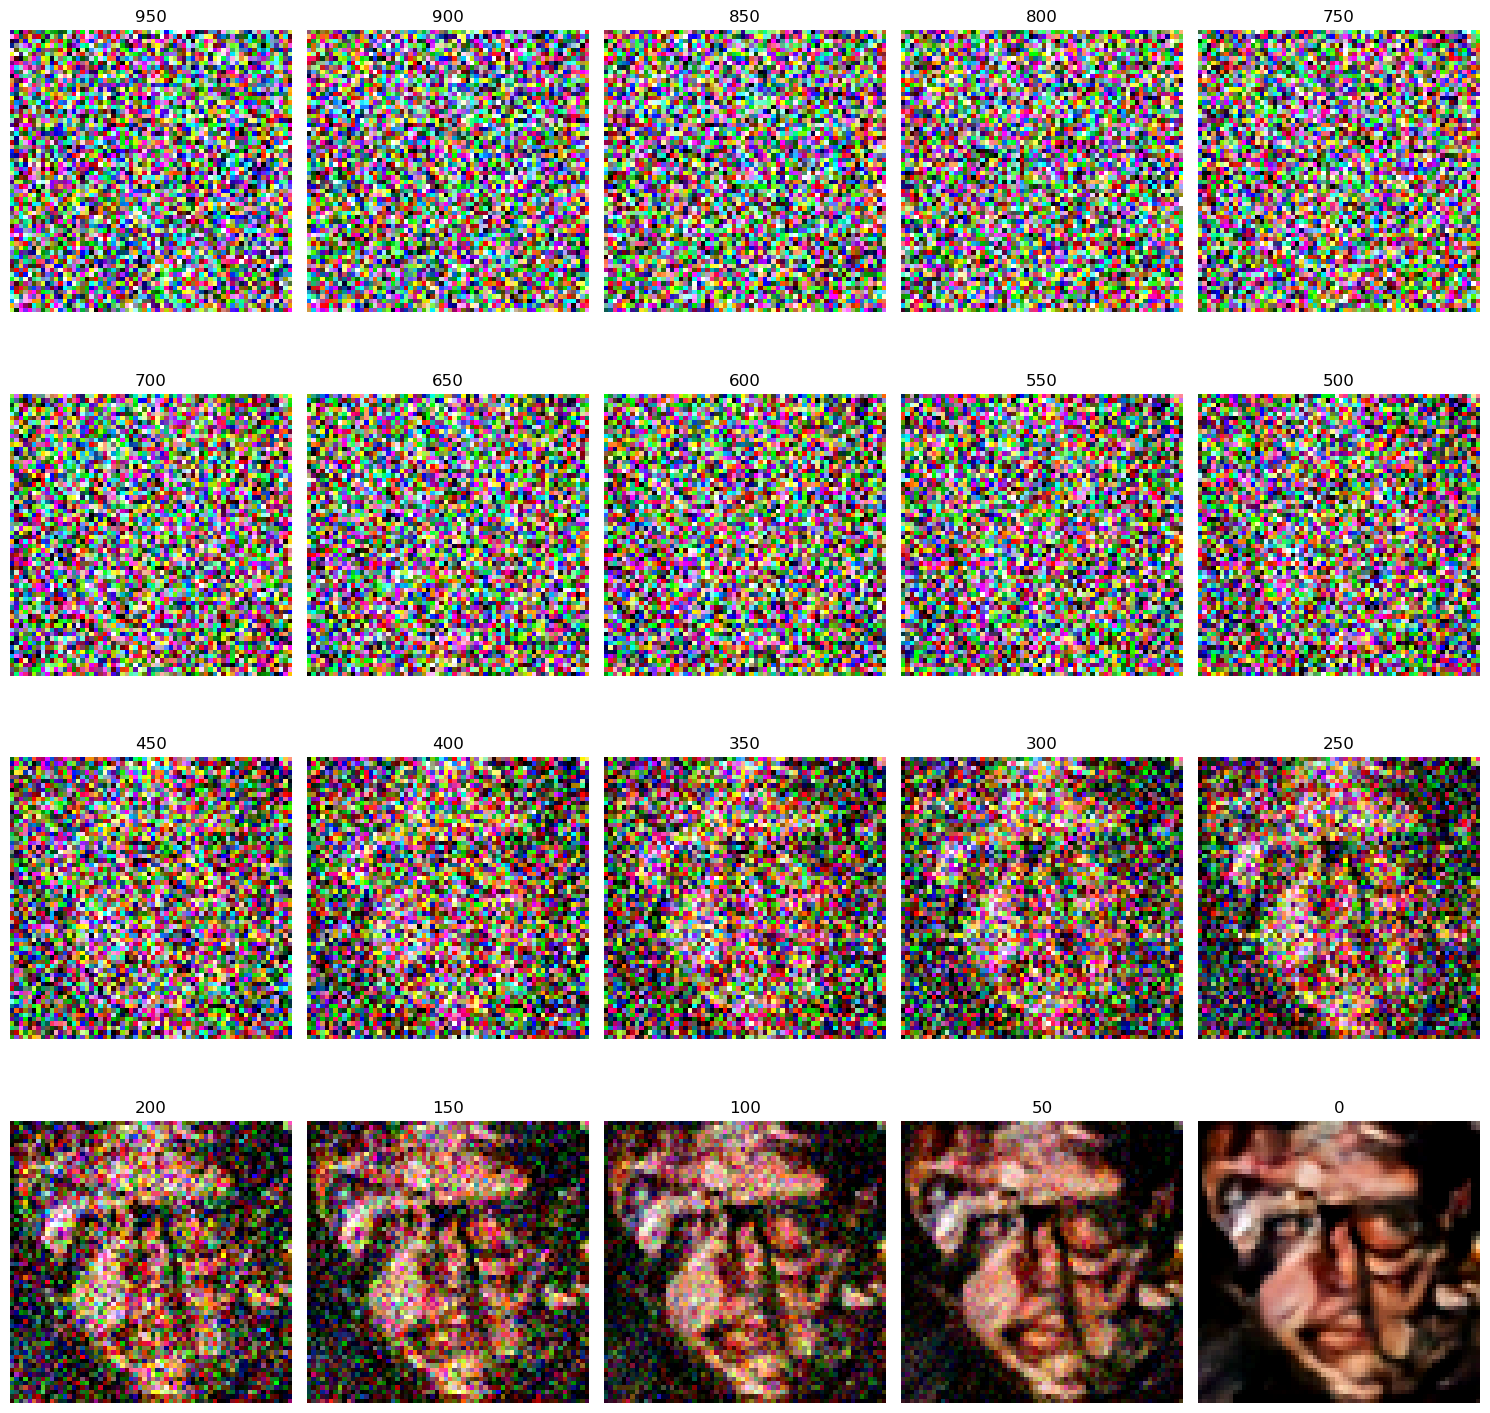

In [64]:
def sample():
	model_sd.eval()
	x = torch.randn(1, 3, 64, 64).cuda()
	y = 1
	cfg = 0.5
	r, c = 4, 5
	fig = plt.figure(figsize=(15,15))
	i = 0
	for t in reversed(range(dataset.T)):
		with torch.no_grad():
			output = model_sd(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
		if t > 0:
			noise = torch.randn_like(x)
		else:
			noise = torch.zeros_like(x)
		# algoritmo para restar el ruido de manera progresiva
		x = 1. / torch.sqrt(dataset.alphas[t]) * (x - ((1. - dataset.alphas[t])/(torch.sqrt(1. - dataset.alphas_hat[t]))) * output) + noise * torch.sqrt(dataset.betas[t])
		if t % 50 == 0:
			i += 1
			ax = plt.subplot(r, c, i)
			ax.imshow(torch.clamp((x[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
			ax.axis("off")
			ax.set_title(t)
	print((x[0].max(),x[0].min()))
	plt.tight_layout()
	plt.show()

sample()

In [65]:
# funcion para generar imagenes
def generar(label=0):
    model_sd.eval()
    r, c = 5, 5
    fig = plt.figure(figsize=(15,15))
    for i in range(r*c):
        x = torch.randn(1, 3, 64, 64).cuda()
        y = label
        for t in reversed(range(dataset.T)):
            with torch.no_grad():
                output = model_sd(x, torch.tensor([t]).cuda(), torch.tensor([y]).long().cuda())
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
            x = 1. / torch.sqrt(dataset.alphas[t]) * (x - ((1. - dataset.alphas[t])/(torch.sqrt(1. - dataset.alphas_hat[t]))) * output) + noise * torch.sqrt(dataset.betas[t])
        ax = plt.subplot(r, c, i + 1)
        ax.imshow(torch.clamp((x[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
        ax.axis("off")
    plt.tight_layout()
    plt.show()

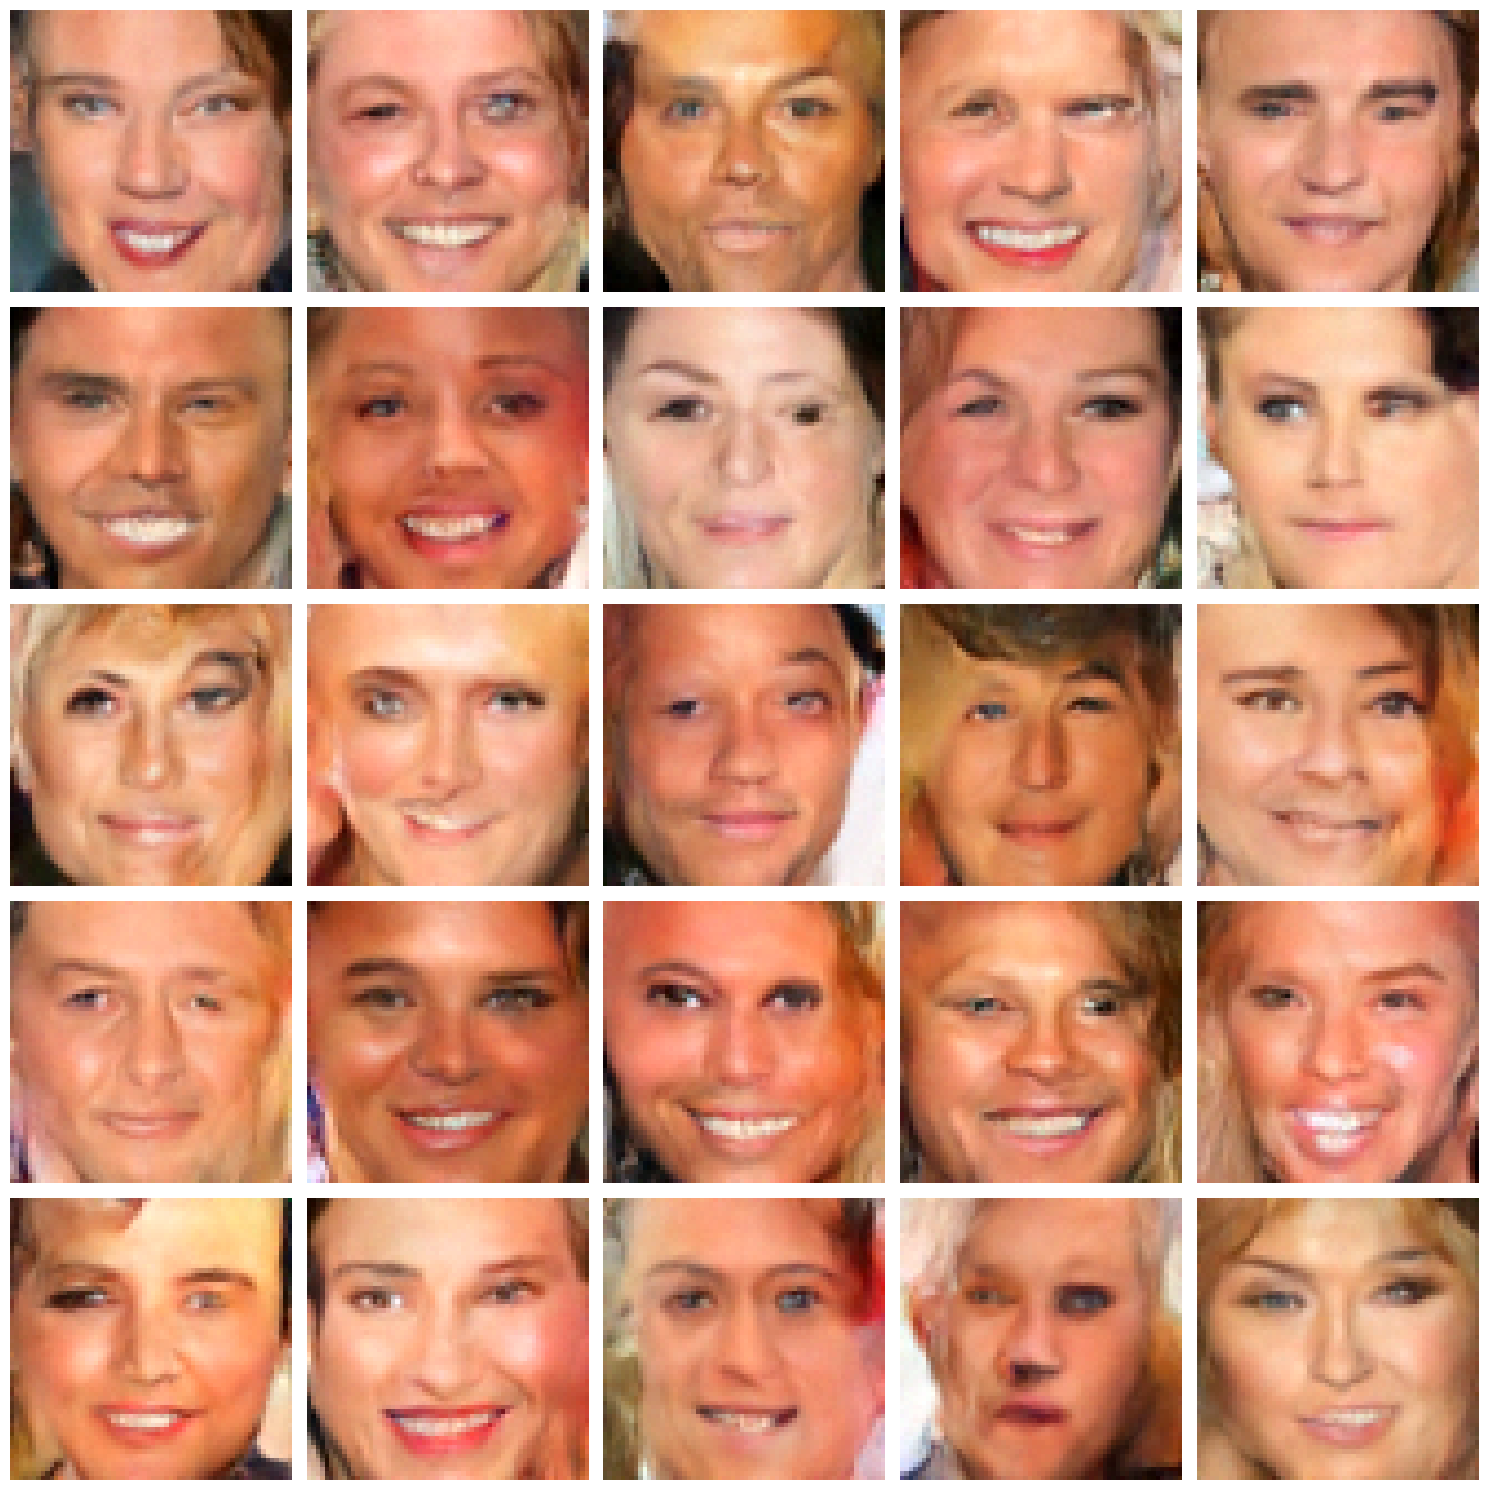

In [66]:
generar(0)# rostro